## Escuela de Ingeniería en Computación, ITCR
## Aprendizaje automático

# Ejemplo con imágenes

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 13s 0us/step
Accuracy usando original: 47.15%
Accuracy usando gray: 41.83%
Accuracy usando normalized: 42.20%
Accuracy usando equalized: 37.50%
Accuracy usando gaussian: 37.89%
Accuracy usando contrast: 37.39%
Accuracy usando thresholded: 35.16%
Accuracy usando rotated: 38.03%
Accuracy usando noisy: 36.99%


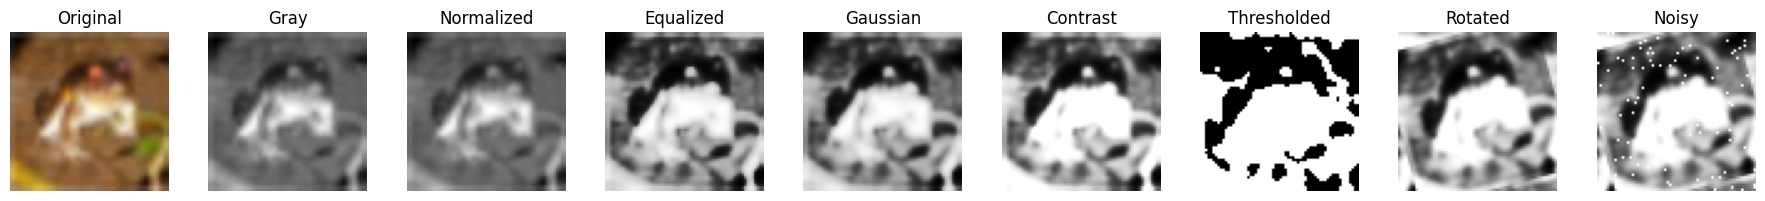

In [ ]:
import numpy as np
from skimage.color import rgb2gray
from skimage.exposure import equalize_hist
from skimage.filters import gaussian
from skimage.util import random_noise
from skimage.transform import resize, rotate
from skimage import img_as_float
from tensorflow.keras.datasets import cifar10
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# Cargar el dataset CIFAR-10
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

# Convertir las imágenes a float
X_train = img_as_float(X_train)
X_test = img_as_float(X_test)

# Definir una función para aplicar varios preprocesamientos
def preprocess_image(image):
    # Redimensionar la imagen
    image_resized = resize(image, (64, 64))  # Redimensionando a 64x64

    # Convertir a escala de grises
    image_gray = rgb2gray(image_resized)

    # Normalización
    image_normalized = (image_gray - np.min(image_gray)) / (np.max(image_gray) - np.min(image_gray))

    # Ecualización del histograma
    image_eq = equalize_hist(image_normalized)

    # Reducción de ruido con filtro gaussiano
    image_gaussian = gaussian(image_eq, sigma=0.5)

    # Ajuste de brillo y contraste (simulación con multiplicación)
    image_contrast = np.clip(image_gaussian * 1.2, 0, 1)

    # Umbralización (binarización)
    threshold = 0.5
    image_thresholded = image_contrast > threshold

    # Aumento de datos: rotación y adición de ruido
    image_rotated = rotate(image_contrast, angle=15, mode='wrap')
    image_noisy = random_noise(image_rotated, mode='salt', amount=0.02)

    return {
        "original": image_resized,
        "gray": image_gray,
        "normalized": image_normalized,
        "equalized": image_eq,
        "gaussian": image_gaussian,
        "contrast": image_contrast,
        "thresholded": image_thresholded,
        "rotated": image_rotated,
        "noisy": image_noisy
    }

# Función para aplanar imágenes para clasificadores
def flatten_images(images):
    return np.array([image.flatten() for image in images])

# Aplanar etiquetas
y_train_flat = y_train.flatten()
y_test_flat = y_test.flatten()

# Diccionario para almacenar los resultados de accuracy
accuracies = {}

# Iterar sobre cada tipo de imagen preprocesada
for key in ["original", "gray", "normalized", "equalized", "gaussian", "contrast", "thresholded", "rotated", "noisy"]:
    # Preprocesar todas las imágenes del conjunto de datos
    X_train_processed = [preprocess_image(image)[key] for image in X_train]
    X_test_processed = [preprocess_image(image)[key] for image in X_test]

    # Aplanar imágenes para el clasificador
    X_train_flat = flatten_images(X_train_processed)
    X_test_flat = flatten_images(X_test_processed)

    # Crear y entrenar el clasificador
    clf = RandomForestClassifier(n_estimators=100, random_state=42)
    clf.fit(X_train_flat, y_train_flat)

    # Realizar predicciones
    y_pred = clf.predict(X_test_flat)

    # Evaluar el modelo y almacenar el resultado
    accuracy = accuracy_score(y_test_flat, y_pred)
    accuracies[key] = accuracy
    print(f'Accuracy usando {key}: {accuracy * 100:.2f}%')

# Visualización de algunas imágenes preprocesadas (opcional)
example_image = X_train[0]
preprocessed_images = preprocess_image(example_image)

fig, axes = plt.subplots(1, 9, figsize=(18, 2))
axes = axes.ravel()

titles = ["Original", "Gray", "Normalized", "Equalized",
          "Gaussian", "Contrast", "Thresholded", "Rotated", "Noisy"]

for i, (title, image) in enumerate(zip(titles, preprocessed_images.values())):
    axes[i].imshow(image, cmap='gray')
    axes[i].set_title(title)
    axes[i].axis('off')

plt.tight_layout()
plt.show()

# Mostrar accuracies
print("\nResultados de accuracy para cada tipo de imagen preprocesada:")
for key, accuracy in accuracies.items():
    print(f'{key}: {accuracy * 100:.2f}%')
